In [1]:
import os
import numpy as np
import pickle
import time

parent_path = os.path.abspath('../')
thin_slice = 30

all_session_ids = []
id_to_feedback = {}
id_to_time = {}
id_to_length = {}

with open(parent_path + '/data/davos/reco_feedback_full.txt', 'r') as f:
    rows = f.readlines()
    for row in rows:
        session_id = row.split()[0]
        all_session_ids.append(session_id)
        feedback = np.array(row.split(" ")[1:]).astype(np.float)
        id_to_feedback[session_id] = feedback

with open(parent_path + '/data/davos/length_full.txt', 'r') as f:
    rows = f.readlines()
    for row in rows:
        session_id = row.split()[0]
        length = int(row.split()[1])
        id_to_length[session_id] = length

with open(parent_path + '/data/davos/reco_times_full.txt', 'r') as f:
    rows = f.readlines()
    for row in rows:
        row = row.rstrip("\n")
        session_id = row.split()[0]
        times = row.split(" ")[1:]
        times_sec = []
        for t in times:
            struct_t = time.strptime(t, '%M:%S.%f')
            tsec = struct_t[4] * 60 + struct_t[5]
            times_sec.append(tsec)
        id_to_time[session_id] = times_sec

In [2]:
# Cluster-0: P-type, Cluster-1: I-type. 0: Rejection, 1: Acceptance.
clusters = pickle.load(open(parent_path + '/data/davos/clusters_full.pkl', 'rb'))
id_to_f = pickle.load(open(parent_path + '/data/davos/id_to_f_full.pkl', 'rb'))

id_to_rapp = {}

avg_rapp = {}
total = np.zeros((2, 2))
num = np.zeros((2, 2))

rapp = [[], []]
feedback = [[], []]
tot_length = np.zeros(2)
num_points = np.zeros(2)

all_rapp_scores = {}
for user_cluster in [0, 1]:
    all_rapp_scores[user_cluster] = {}
    for task_perf in [0, 1]:
        all_rapp_scores[user_cluster][task_perf] = []

count = 0
for i, sid in enumerate(all_session_ids):
    count += id_to_feedback[sid].shape[0]
    f = id_to_f[sid]
    id_to_rapp[sid] = np.array([f(t).tolist() for t in id_to_time[sid]])
    
    c = int(clusters[int(sid)])
    
    rapp[c].extend(id_to_rapp[sid].tolist())
    feedback[c].extend(id_to_feedback[sid].tolist())
    
    # Total rapport and number of recos for rejects
    total[c][0] += np.dot(id_to_rapp[sid], 1 - id_to_feedback[sid])
    num[c][0] += np.sum(1 - id_to_feedback[sid])
    vals = id_to_rapp[sid] * (1 - id_to_feedback[sid])
    all_rapp_scores[c][0].extend(vals[vals > 0].tolist())
    
    # Total rapport and number of recos for accepts
    total[c][1] += np.dot(id_to_rapp[sid], id_to_feedback[sid])
    num[c][1] += np.sum(id_to_feedback[sid])
    vals = id_to_rapp[sid] * (id_to_feedback[sid])
    all_rapp_scores[c][1].extend(vals[vals > 0].tolist())

    tot_length[c] += id_to_length[sid]
    num_points[c] += 1

print(total/num)
print(num)
print("Count: ", count)
print("Avg. length: ", tot_length/num_points)
print("Cluster distribution: ", num_points)

for user_cluster in [0, 1]:
    for task_perf in [0, 1]:
        print("Average: ", np.average(np.array(all_rapp_scores[user_cluster][task_perf])))
        print("Std. Dev.: ", np.std(np.array(all_rapp_scores[user_cluster][task_perf])))

for i in range(2):
    print(np.corrcoef(np.array(rapp[i]), np.array(feedback[i])))

all_rapps_gold = []
for i in range(2):
    all_rapps_gold.extend(rapp[i])
pickle.dump(all_rapps_gold, open(parent_path + '/data/davos/all_rapps_gold_full.pkl', 'wb'))

[[3.93881659 4.02753593]
 [4.15154367 4.42296844]]
[[49. 74.]
 [26. 41.]]
Count:  190
Avg. length:  [298.04761905 319.60869565]
Cluster distribution:  [42. 23.]
Average:  3.938816594818027
Std. Dev.:  0.7495970982718039
Average:  4.027535933781964
Std. Dev.:  0.7979567644156502
Average:  4.151543671526406
Std. Dev.:  0.5833032145968741
Average:  4.422968435395392
Std. Dev.:  0.7372701329544832
[[1.         0.05566562]
 [0.05566562 1.        ]]
[[1.         0.19048367]
 [0.19048367 1.        ]]


Cluster-1 (I-type):
- 3.75
- 4.37

Cluster-2 (P-type):
- 3.98
- 3.94

Next steps:
1) Add word count information for cluster determination
2) Restrict conversational strategy profiling to the initial part of the conversation (before first recommendation)
3) Change reject to accept for "interesting reco (but already know this person)"
4) Calculate correlation

(2,)
0.5
(16,)
0.4375
(37,)
0.6756756756756757
(11,)
0.7272727272727273


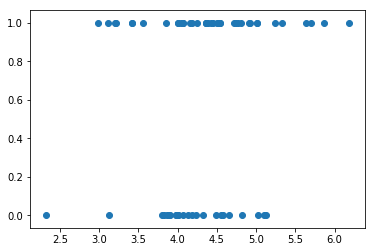

In [4]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.utils import resample
from xgboost import XGBClassifier
from sklearn.linear_model import Perceptron
from sklearn.svm import LinearSVC
from sklearn import preprocessing
from sklearn.model_selection import LeaveOneOut
import matplotlib.pyplot as plt

scaler = preprocessing.StandardScaler()

#np.random.seed(0)

clust = 1
clf = LogisticRegression(penalty = 'l1', random_state=200)

if clust == 'all':
    X = np.concatenate((np.array(rapp[0])[:, np.newaxis], np.array(rapp[1])[:, np.newaxis]), axis=0)
    y = np.concatenate((np.array(feedback[0]), np.array(feedback[1])), axis=0)
else:
    X = np.array(rapp[clust])[:, np.newaxis]
    y = np.array(feedback[clust])

#X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1)

# print(np.average(X[np.where(y == 0)[0]]))
# print(np.std(X[np.where(y == 0)[0]]))
# print(np.average(X[np.where(y == 1)[0]]))
# print(np.std(X[np.where(y == 1)[0]]))

print(np.shape(y[np.where(X < 3)[0]]))
print(np.average(y[np.where(X < 3)[0]]))
print(np.shape(y[np.where((X > 3) & (X < 4))[0]]))
print(np.average(y[np.where((X > 3) & (X < 4))[0]]))
print(np.shape(y[np.where((X > 4) & (X < 5))[0]]))
print(np.average(y[np.where((X > 4) & (X < 5))[0]]))
print(np.shape(y[np.where((X > 5))[0]]))
print(np.average(y[np.where((X > 5))[0]]))

plt.scatter(rapp[clust], y)
plt.show()

# Resample
# y_0 = y_train[np.where(y_train == 0)[0]]
# X_0 = X_train[np.where(y_train == 0)[0]]

# y_1 = y_train[np.where(y_train == 1)[0]]
# X_1 = X_train[np.where(y_train == 1)[0]]

# X_0, y_0 = resample(X_0, y_0, replace=True, n_samples=X_1.shape[0])
# X_train = np.concatenate((X_0, X_1), axis=0)
# y_train = np.concatenate((y_0, y_1), axis=0)

# plt.scatter(rapp[clust], feedback[clust])
# plt.show()

# loo = LeaveOneOut()
# loo.get_n_splits(X)

# total_acc = 0
# count = 0
# for train_index, test_index in loo.split(X):
#     X_train, X_test = X[train_index], X[test_index]
#     y_train, y_test = y[train_index], y[test_index]
    
#     # Resample
#     y_0 = y_train[np.where(y_train == 0)[0]]
#     X_0 = X_train[np.where(y_train == 0)[0]]

#     y_1 = y_train[np.where(y_train == 1)[0]]
#     X_1 = X_train[np.where(y_train == 1)[0]]

#     X_0, y_0 = resample(X_0, y_0, replace=True, n_samples=X_1.shape[0])
#     X_train = np.concatenate((X_0, X_1), axis=0)
#     y_train = np.concatenate((y_0, y_1), axis=0)
    
#     clf.fit(X_train, y_train)
#     y_pred = clf.predict(X_test)
#     acc = accuracy_score(y_pred, y_test)
#     total_acc += acc
#     count += 1

# print(total_acc/count)
    

# scaler.fit(X_train)
# print(scaler.mean_)
# print(scaler.scale_)

#clf.fit(X_train, y_train)

#X_test = scaler.transform(X_test)
# y_pred = clf.predict(X_test)
# acc = accuracy_score(y_pred, y_test)
# print(acc)
# print(y_pred)
# print(y_test)

# conf_mat = confusion_matrix(y_true=y_test, y_pred=y_pred)
# print('Confusion matrix:\n', conf_mat)

# y_pred = clf.predict(X_train)
# acc = accuracy_score(y_pred, y_train)
# print(acc)

# print(clf.coef_)
# print(clf.intercept_)

(array([49.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0., 74.]),
 array([0.  , 0.02, 0.04, 0.06, 0.08, 0.1 , 0.12, 0.14, 0.16, 0.18, 0.2 ,
        0.22, 0.24, 0.26, 0.28, 0.3 , 0.32, 0.34, 0.36, 0.38, 0.4 , 0.42,
        0.44, 0.46, 0.48, 0.5 , 0.52, 0.54, 0.56, 0.58, 0.6 , 0.62, 0.64,
        0.66, 0.68, 0.7 , 0.72, 0.74, 0.76, 0.78, 0.8 , 0.82, 0.84, 0.86,
        0.88, 0.9 , 0.92, 0.94, 0.96, 0.98, 1.  ]),
 <a list of 50 Patch objects>)

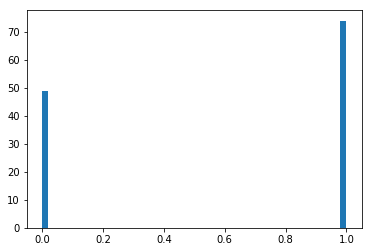

In [45]:
min_x = 2
max_x = 6

xlims = np.arange(min_x, max_x + 1)
acceptance_rate = np.zeros(max_x - min_x + 1)
for i in range(min_x, max_x):
    acceptance_rate[i-2] = np.average(y[np.where((X > i) & (X <= i+1))[0]])

plt.hist(y, bins=50)

In [13]:
import math

muA = 0.23
muB = 0.18
stdA = 0.01
stdB = 0.01
nA = 10
nB = 10
sAB = math.sqrt(((nA-1)*stdA**2 + (nB-1)*stdB**2)/(nA+nB-2))

t_den = sAB * math.sqrt(1.0/nA + 1.0/nB)
t_num = abs(muA-muB)
print(t_num/t_den)

11.18033988749895
